<a href="https://colab.research.google.com/github/ashwingeeni12/data_science_fundamentals/blob/main/Unit_4/AshwinGeeni_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)

In [ ]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [ ]:
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [ ]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
with pm.Model(coords=aa_coords) as cs_oh_model: #This is the original model where we used Normal and HalfNormal
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_oh = pm.sample()

Output()

Output()

In [ ]:
with pm.Model(coords=aa_coords) as cs_nh_model: #This is my new model with studentt
    # Hyperpriors: shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu=0, sigma=10, nu=5)
    μ_sd = pm.HalfStudentT('μ_sd', nu=3, sigma=10)  # Change to HalfStudentT with nu parameter
    μ_nu = pm.HalfStudentT('μ_nu', nu=30, sigma =10)

    # Priors for each amino acid: use StudentT instead of Normal
    μ = pm.StudentT('μ', nu=μ_nu, mu=μ_mu, sigma=μ_sd, dims="aa")  # StudentT with nu for group means

    # Priors for standard deviation: HalfStudentT instead of HalfNormal
    σ = pm.HalfStudentT('σ', nu=30, sigma=10, dims="aa")  # HalfStudentT with nu for standard deviation

    v = pm.HalfStudentT('v', nu=30, sigma=10, dims = "aa")

    # Likelihood: use StudentT instead of Normal
    y = pm.StudentT('y', nu=v[aa_idx], mu=μ[aa_idx], sigma=σ[aa_idx], observed=cs_data['diff_TminusE'])

    # Sampling from the posterior
    idata_cs_nh = pm.sample()

Output()

Output()

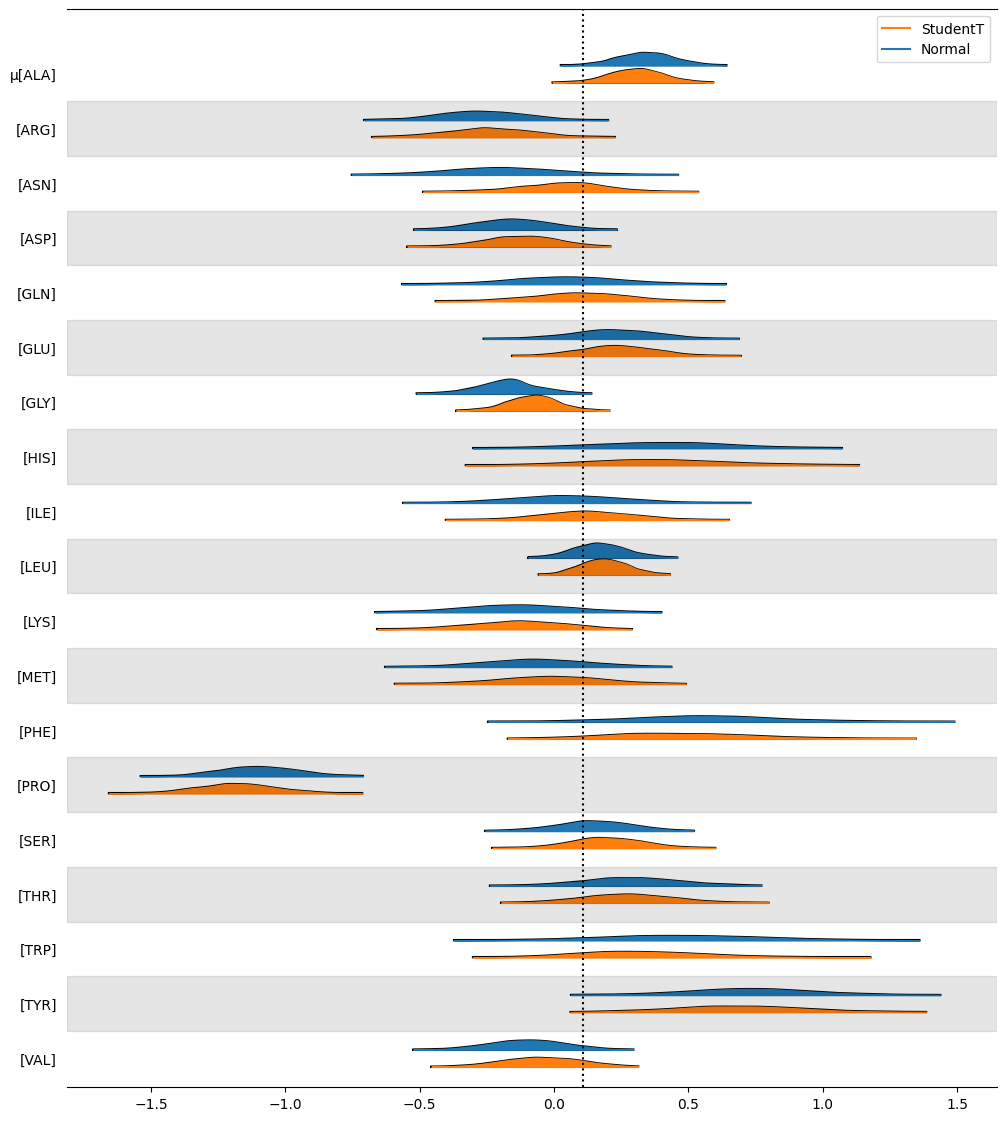

In [ ]:
axes = az.plot_forest([idata_cs_oh, idata_cs_nh], kind="ridgeplot",
                      model_names=['Normal', 'StudentT'],
                      var_names='μ', combined=True, figsize=(12, 14), hdi_prob=0.997)

y_lims = axes[0].get_ylim()

axes[0].vlines(idata_cs_nh.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":")

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

(-15.0, 15.0)

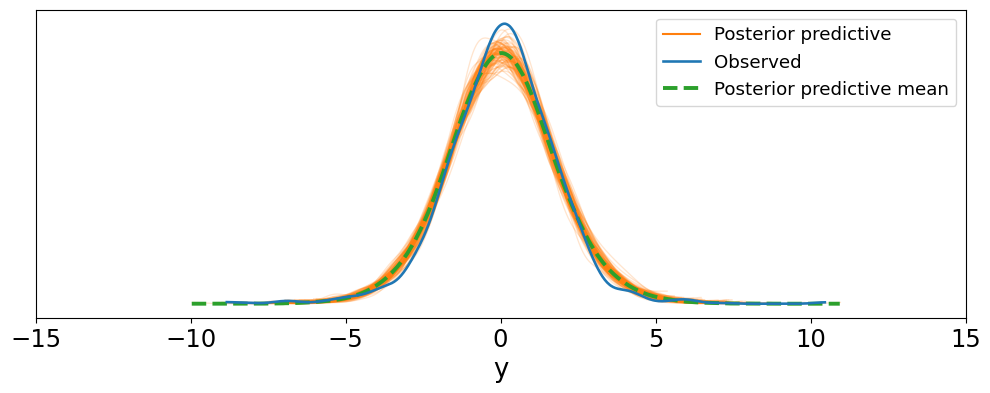

In [ ]:
#ppc for the normal one
pm.sample_posterior_predictive(idata_cs_oh, model=cs_oh_model, extend_inferencedata=True)

az.plot_ppc(idata_cs_oh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"]).set_xlim(-15,15)

Output()

(-15.0, 15.0)

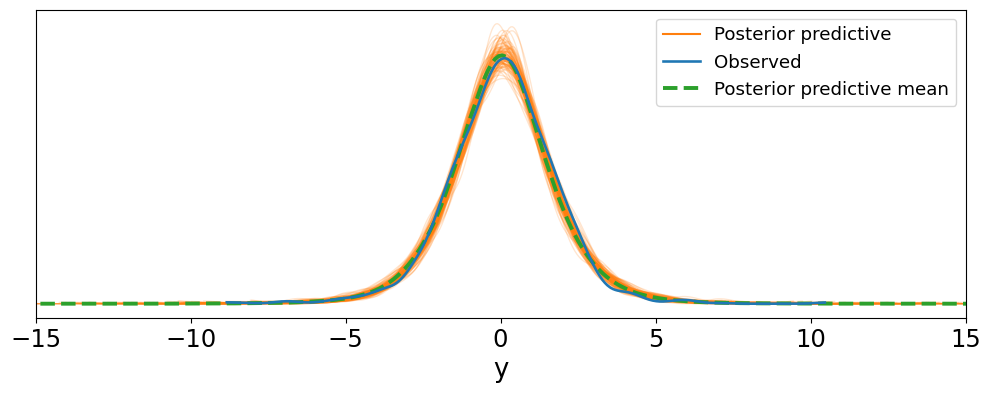

In [43]:
#ppc for the new one with student t
pm.sample_posterior_predictive(idata_cs_nh, model=cs_nh_model, extend_inferencedata=True)

az.plot_ppc(idata_cs_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"]).set_xlim(-15,15)

The new hierarchal model, StudentT & HalfStudentT, fits the data better as the posterior predictive mean is really similar to the observed. While, in the old hierarchal model the observed is above the posterior predictive mean especially when comparing the peaks of both curves.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [21]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [22]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [30]:
with pm.Model(coords = sccr_coords) as sccr_nh_model: # non hierachical

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 2/22, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_nh_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

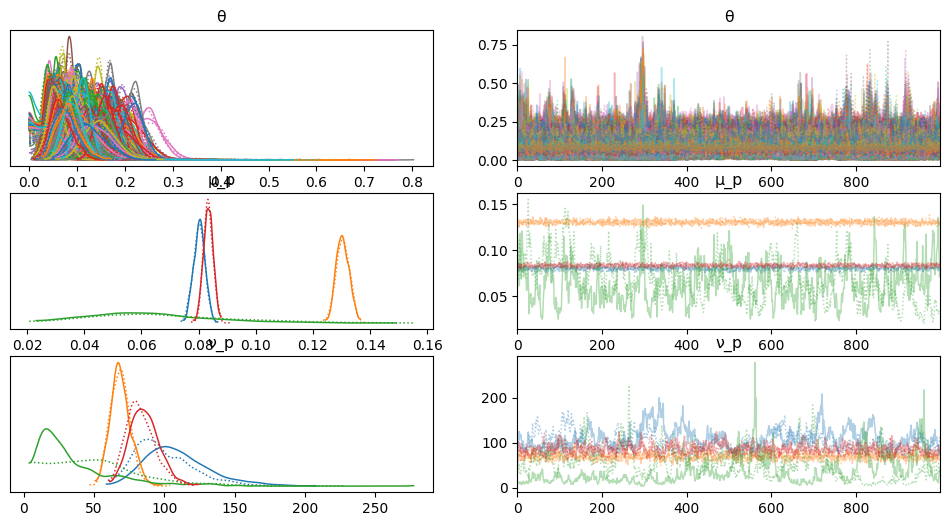

In [31]:
az.plot_trace(idata_nh_sccr)

In [32]:
az.rhat(idata_nh_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.006 1.002 1.0 1.002 ... 1.007 1.002 1.006
    μ_p      (pos) float64 32B 1.001 1.0 1.082 0.9996
    ν_p      (pos) float64 32B 1.042 1.0 1.227 1.02

In [26]:
with pm.Model(coords = sccr_coords) as sccr_h_model: #hierarchical
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_h_sccr = pm.sample(target_accept = 0.95)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

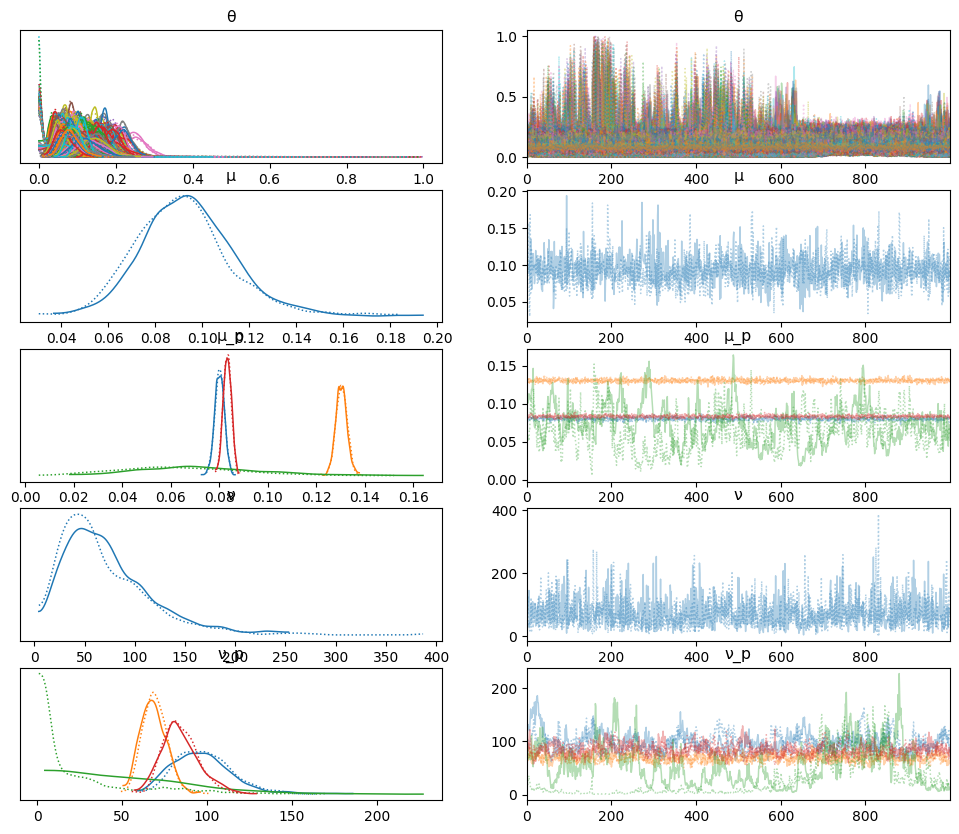

In [28]:
az.plot_trace(idata_h_sccr)

In [29]:
az.rhat(idata_h_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.002 0.9994 1.005 ... 1.006 1.004 1.002
    μ        float64 8B 1.01
    μ_p      (pos) float64 32B 1.0 1.0 1.074 0.9994
    ν        float64 8B 1.006
    ν_p      (pos) float64 32B 1.01 1.003 1.509 1.01

The nonhierarchical R values are generally farther from 1 compared to the hierarchical R values for the parameters they share μp, 𝜈p, and θ. This difference is especially noticeable for 𝜈p, where the nonhierarchical model's R is higher than that of the hierarchical model. However, the θ and μp values are quite close between the two models, both being near 1. θ is the only parameter with R values that occasionally fall below 1.

In the trace plots, θ is similarly bounded in both models, staying below a particular threshold, though the nonhierarchical model exhibits slightly more extreme values meaning we are less confident in those predictions. For μp and 𝜈p, the nonhierarchical model shows more frequent outliers, and values reach higher levels than in the hierarchical model. For instance, while the hierarchical 𝜈p traces only occasionally exceed a certain point, the nonhierarchical 𝜈p traces go notably higher. Nonetheless, the overall patterns of μp and 𝜈p traces are relatively similar between models.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

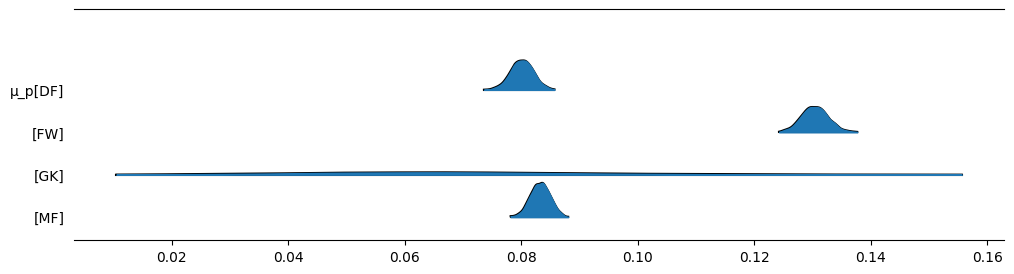

In [33]:
# plots a 99.8% HDI for the positions shooting percentage means
#hierarchical
az.plot_forest(idata_h_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

array([<Axes: >], dtype=object)

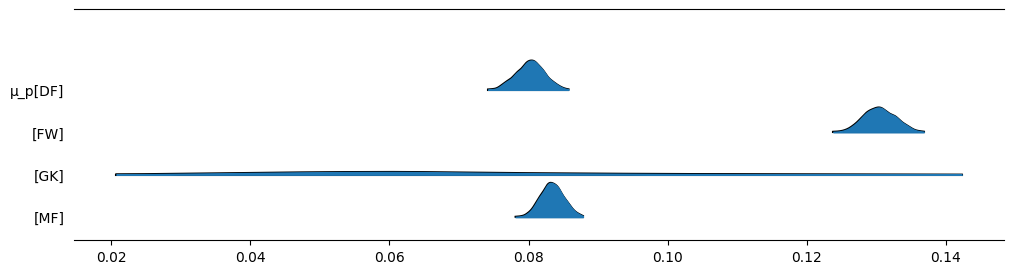

In [34]:
#non- hierarchical
az.plot_forest(idata_nh_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The posterior distributions of the hierarchical and nonhierarchical models are pretty similar. For non-goalkeeper positions, the look really similar in terms of peaks and shapes. Overall there seems to be a slight negative skew for the non-hierarchical compared to the hierarchical. However, both models seem to be wack with the goalkeeper position, basically showing a straight line there. One difference is the range of the x-values: the hierarchical model's values extend up to approximately 0.16, while the nonhierarchical model goes only up to about 0.14.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [36]:
sccr_data_no_GK = pd.read_csv(url_sccr)
sccr_data_no_GK = sccr_data_no_GK.query('position != "GK"')
sccr_data_no_GK.reset_index(drop = True, inplace = True)
sccr_data_no_GK['position'] = sccr_data_no_GK['position'].astype('category')
sccr_data_no_GK

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2512,Óscar Mingueza,DF,2,12
2513,Óscar Plano,MF,12,124
2514,Óscar Rodríguez,MF,13,133
2515,Óscar Trejo,MF,1,20


In [38]:

pos_idx = sccr_data_no_GK.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data_no_GK.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords_new = {"pos": pos_codes}

sccr_coords_new

{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}

In [44]:
with pm.Model(coords = sccr_coords_new) as sccr_model_no_GK:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_no_GK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_no_GK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_no_GK = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

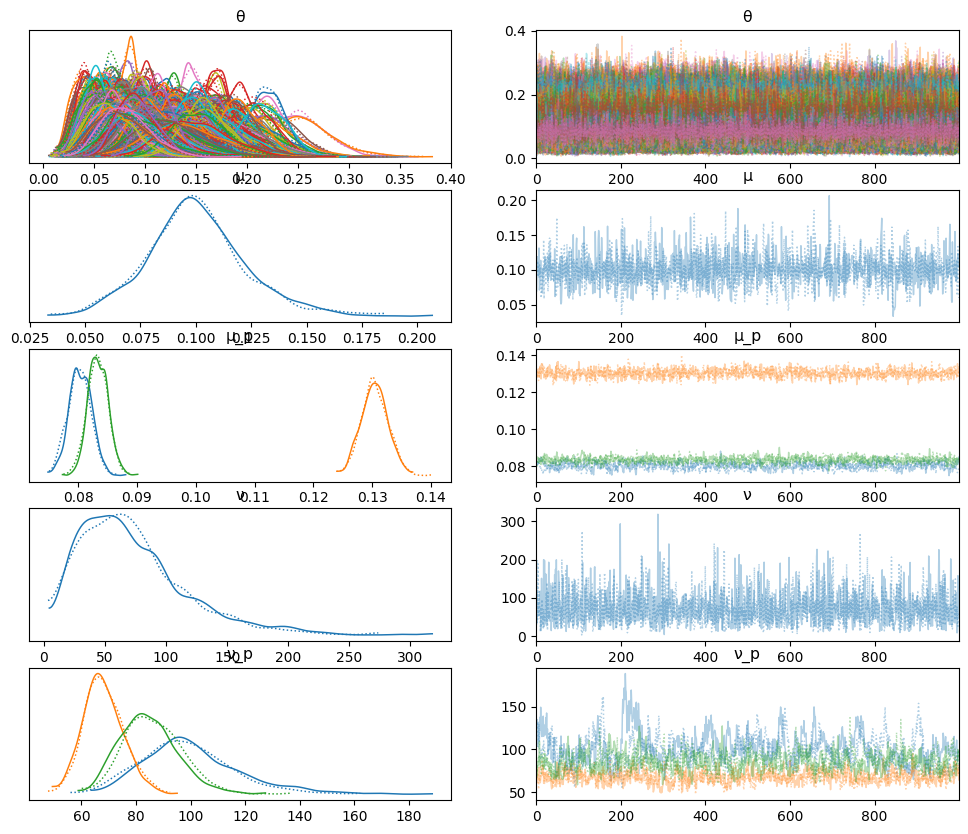

In [45]:
az.plot_trace(idata_sccr_no_GK)

In [46]:
az.rhat(idata_sccr_no_GK)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.001 1.005 1.002 0.9996 ... 0.9995 1.0 1.0
    μ        float64 8B 1.003
    μ_p      (pos) float64 24B 1.004 1.001 1.003
    ν        float64 8B 0.9995
    ν_p      (pos) float64 24B 1.01 1.007 1.017

The one without Goal Keeper would be faster because there is less data to parse through therby making it easier for pymc to process. Also there are 0/0 errors which pymc has to account for. Also high variability if the GK does indeed score.

By dropping the GK stats we lose some data but make the graphs as a whole better as we get more consistency. This can be seen directly when comparing the R vlaues.